# Import packages

### Import python packages

In [1]:
import re,os,glob
os.environ["CUDA_VISIBLE_DEVICES"]="6"
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import clear_output
import pandas as pd
import math
import random
from datetime import datetime
from scipy.stats import linregress
from sklearn.decomposition import PCA
from tqdm import trange, tqdm
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE
import scipy
from scipy import interpolate
tfk = tf.keras
tfkl = tf.keras.layers
clear_output()
from MRA_generate import MRA_generate
from parameters import *
import symae_core as symae
from movie_redatum import movie_redatum 

# Generate dataset X

### Define $n_\varepsilon$ states

In [2]:
def g(n,x):
    if n==0:
        return int(x<0.5)
    elif n==1:
        return math.cos(2*math.pi*x)/2 + 0.5
    elif n==2:
        if x<0.5: 
            return 1-2*x
        else:     
            return 0
    elif n==3:
        return 2*int(x<0.5)-1
    elif n==4:
        return math.cos(2*math.pi*x)
    elif n==5:
        if x<0.5: 
            return 1-4*x
        else:     
            return -1

Text(0.5, 0.98, 'Show the shape of all $n_\\epsilon$ = 6 states')

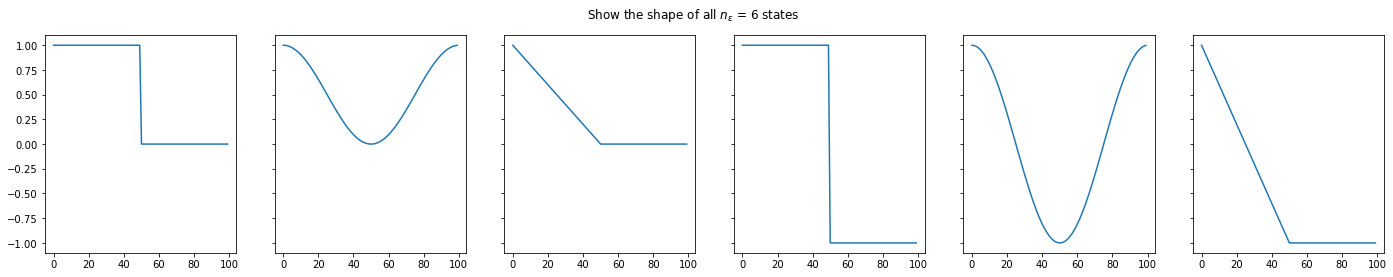

In [3]:
fig, axs = plt.subplots(1, ne, sharex=True, sharey=True, figsize=(ne*4, 4))
for i in range(ne):
    axs[i].plot(range(d), [g(i,x/d) for x in range(d)])
plt.suptitle('Show the shape of all $n_\epsilon$ = %d states'%ne)

### Generate the dataset

In [4]:
MRA_training = MRA_generate(d,nt,N,0,ne,g,replace=0,continuous=False)
MRA_training.generate_default()
X = MRA_training.X
states = MRA_training.states
shifts = MRA_training.shifts

### Print the structure of dataset X

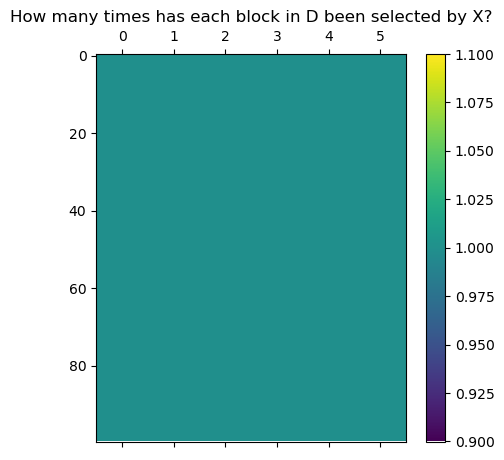

In [5]:
select_times = MRA_training.select_times
plt.figure(figsize=(5,5),dpi=100)
plt.matshow(select_times.T, aspect='auto', fignum=1)
plt.colorbar()
plt.title('How many times has each block in D been selected by X?')
plt.show()

# Train SymAE

In [6]:
nt

20

### Layer

In [7]:
class LatentCat(tf.keras.Model):
    def __init__(self, alpha=0.5):
        super(LatentCat, self).__init__(name = 'latentcat')
        self.drop = tfkl.GaussianDropout(alpha)
    def call(self, zsym, znuisance, training=False):
        znuisance = self.drop(znuisance, training=training)
        znuisance = tfkl.Flatten()(znuisance)
        z = tfkl.concatenate([zsym, znuisance])
        return z

In [8]:
class SymAE(tf.keras.Model):
    def __init__(self, N, nt, d, p, q, r): 
        super(SymAE, self).__init__()
        # Build symmetric encoder
        sym_encoder = symae.SymmetricEncoder1D(p)
        self.sym_encoder = sym_encoder
        
        # Build nuisance encoder
        nui_encoder = symae.NuisanceEncoder1D(q)
        self.nui_encoder = nui_encoder
        
        # Build distribute in decoder
        distzsym = symae.DistributeZsym(nt, p, q)
        self.distzsym = distzsym
        
        #Build mixer in decoder
        mixer = symae.Mixer1D(d)
        self.mixer = mixer
        
        # Build latentcat
        latentcat = LatentCat(r)
        self.latentcat = latentcat        
        
        # Build encoder
        encoder_input = tfk.Input(shape=(nt,d,1), dtype='float32', name='encoder_input')
        znuisance = nui_encoder(encoder_input)
        zsym = sym_encoder(encoder_input)
        encoder_output = latentcat(zsym,znuisance)
        encoder = tfk.Model(encoder_input, encoder_output, name="encoder")
        self.encoder = encoder
        
        # Build decoder
        decoder_input = tfk.Input(shape=(p+q*nt), name='latentcode')
        decoder_output = mixer(distzsym(decoder_input))
        decoder = tfk.Model(decoder_input,decoder_output, name="decoder") 
        self.decoder = decoder
        
    def call(self, x):
        sym_code = self.sym_encoder(x)
        nui_code = self.nui_encoder(x)
        z = self.latentcat(sym_code, nui_code)
        dist = self.distzsym(z)
        out = self.mixer(dist)
        return out

### Initialize SymAE and load weights

In [9]:
def redatum_loss(model):
    Xs = np.empty((1,nt,d,1))
    Xn = np.empty((1,nt,d,1))
    for i in trange(ne):
        storage = np.empty((d,d))
        reall=np.empty((d,d))
        for l in range(d):
            ##### reconstruct #####
            Xs[0,0,:,0] = [g(i,((k+l)%d)/d) for k in range(d)]
            for t in range(1,nt):
                l = np.random.randint(d)
                Xs[0,t,:,0] = [g(i,((k+l)%d)/d) for k in range(d)]
            ##### redatum #####
            c=0
            if i==0:
                c=1
            elif i==1:
                c=2
            elif i==2:
                c=0
            elif i==3:
                c=5
            elif i==4:
                c=3
            elif i==5:
                c=4
            Xn[0,0,:,0] = [g(c,((k+l)%d)/d) for k in range(d)]
            for t in range(1,nt):
                l = np.random.randint(d)
                Xn[0,t,:,0] = [g(c,((k+l)%d)/d) for k in range(d)]
            Zs = model.sym_encoder(Xs)
            Zn = model.nui_encoder(Xn)
            merger = model.latentcat(Zs, Zn, training=False)
            redatum = model.decoder(merger)
            storage[l,:]=redatum[0,0,:,0]
            reall[l,:] = [g(i,((k+l)%d)/d) for k in range(d)]
        s=100
        flag = 0
        for ll in range(d):
            ss=0
            for ii in range(d):
                for jj in range(d):
                    ss+=(storage[ii,(jj+ll)%d]-reall[ii,jj])**2
            ss/=d**2
            if ss<s:
                flag=ll
                s=ss
        print(flag,s)

In [10]:
#redatum_loss(model)

In [16]:
my_list=[(2, 2, 0.5, 0)
        ]

In [ ]:
for (p,q,r,lam) in my_list:
    path = './N=%d,nt=%d,p=%d,q=%d,r=%.1f,l=%.2f'%(N,nt,p,q,r,lam)    
    path = './p=%d,q=%d,r=%.1f,l=%.3f'%(p,q,r,lam)    
    #import symae_model 
    model = SymAE(N,nt,d,p,q,r)
    #model = symae_model.SymAE(N,nt,d,p,q,5,64,0.0)
    clear_output()
    #lam=10
    try: 
        model.load_weights(path+'/checkpoint')
        #model.load_weights('./p=%d,q=%d,r=%.1f,l=%.3f'%(p,q,0.1,lam)+'/checkpoint')
        print("old")    
    except:
        print("new")
    #lam=10
    optimizer = tf.keras.optimizers.Adam(0.001)
    mse = tf.keras.losses.MeanSquaredError()

    def reconstruction_loss(model, x, training=False):
        x_hat = model(x, training=True)
        return mse(x, x_hat)
    def norm(x, ord=2, axis=-1):
        if ord==1:
            return tf.math.abs(x,axis=axis)
        elif ord==2:
            return tf.sqrt(tf.reduce_sum(tf.square(x), axis=axis) + 1.0e-12)
    @tf.function
    def set_distance(s1,s2):
        ''' |s1|=N*|s2| '''
        '''WARNING: this layer rely on broadcasting'''
        s1_ = tf.expand_dims(s1, 0)
        s1__ = tf.expand_dims(s1, 1)
        s2_ = tf.expand_dims(s2, 0)
        s2__ = tf.expand_dims(s2, 1)
        s12 = tf.reduce_mean(norm(s1_-s2__, axis=-1))
        s11 = tf.reduce_mean(norm(s1_-s1__, axis=-1))
        s22 = tf.reduce_mean(norm(s2_-s2__, axis=-1))
        s = s12-s11/2-s22/2
        return s
    def mutual_info_penalty(model, x, training=False):
        z = model.encoder(x, training=False)
        coherent_code = z[:,0:p]
        nuisance_code = z[:,p:p+nt*q]
        all_points = tf.reshape(nuisance_code,[-1,q])
        std = tf.math.reduce_std(all_points, 0)
        std = tf.ones_like(std)
        s = 0.0
        for i in trange(z.shape[0]):
            s += set_distance(all_points, all_points[i*nt:(i+1)*nt,:])
        return s
    @tf.function
    def train_step(model, x, training=True):
        with tf.GradientTape() as tape:
            loss_rec = reconstruction_loss(model, x, training)
            loss_cor = mutual_info_penalty(model, x, training)*lam
            loss = loss_rec + loss_cor
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss_rec, loss_cor

    try:
        os.mkdir(path)
    except:
        print('exists')

    try:
        epoch = int(re.findall(r"\d+",glob.glob(path+'/*.epoch')[0])[-1])
        print(epoch)
    except:
        epoch = 0
        os.mkdir(path+'/0.epoch')
    MRA_test = MRA_generate(d,nt,100,sigma,ne,g,replace=0,continuous=False)
    MRA_test.generate_default()
    clear_output()
    N_states = np.repeat(MRA_test.states,nt)
    N_shifts = MRA_test.shifts.reshape(-1,1)
    df_states = pd.DataFrame(1+N_states,columns=['state']).astype('object')
    df_shifts = pd.DataFrame(N_shifts,columns=['shift'])
    for i in range(10000):
        #print(model.latentcat.drop.rate)
        #model.latentcat.drop.rate *= 0.999
        epoch += 1
        os.mkdir(path+'/%d.epoch'%epoch)
        os.rmdir(path+'/%d.epoch'%(epoch-1))    
        loss_rec, loss_cor = train_step(model, X)
        print("For epoch {:d}, reconstruction loss is {:f}, correlation loss is {:f}."
              .format(epoch, loss_rec, loss_cor))
        clear_output(wait=True)
        if epoch%100==0:
            model.save_weights(path+'/checkpoint')
        if epoch%100==-1:
            N_code = model.nui_encoder.predict(MRA_test.X,verbose=0)
            N_reshaped = N_code.reshape(-1,q)
            pca_N = PCA(2).fit_transform(N_reshaped)
            df = pd.DataFrame(pca_N, columns = ['first principal component','second principal component'])
            df = pd.concat([df,df_states,df_shifts],axis=1)
            df = df.sort_values(by=['state'])
            fig = px.scatter(df, x='first principal component', y='second principal component', 
                             color='state', text='shift')
            fig.update_layout(width=500, height=400, title="PCA of latent nuisance codes")
            fig.show()
            fig.write_image(path+'/latent.pdf')

    model.save_weights(path+'/checkpoint')
    print("weights saved")

    fig = movie_redatum(g,model)
    fig.savefig(path+"/redatum.pdf", format='pdf', dpi=200)

    MRA_test = MRA_generate(d,nt,100,sigma,ne,g,replace=0,continuous=False)
    MRA_test.generate_default()
    clear_output()
    N_states = np.repeat(MRA_test.states,nt)
    N_shifts = MRA_test.shifts.reshape(-1,1)
    df_states = pd.DataFrame(1+N_states,columns=['state']).astype('object')
    df_shifts = pd.DataFrame(N_shifts,columns=['shift'])

    N_code = model.nui_encoder.predict(MRA_test.X,verbose=0)
    N_reshaped = N_code.reshape(-1,q)
    pca_N = PCA(2).fit_transform(N_reshaped)
    df = pd.DataFrame(pca_N, columns = ['first principal component','second principal component'])
    df = pd.concat([df,df_states,df_shifts],axis=1)
    df = df.sort_values(by=['state'])
    fig = px.scatter(df, x='first principal component', y='second principal component', 
                     color='state', text='shift')
    fig.update_layout(width=500, height=400, title="PCA of latent nuisance codes")
    fig.show()
    fig.write_image(path+'/latent.pdf')

For epoch 1848, reconstruction loss is 0.145525, correlation loss is 0.000000.


100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]


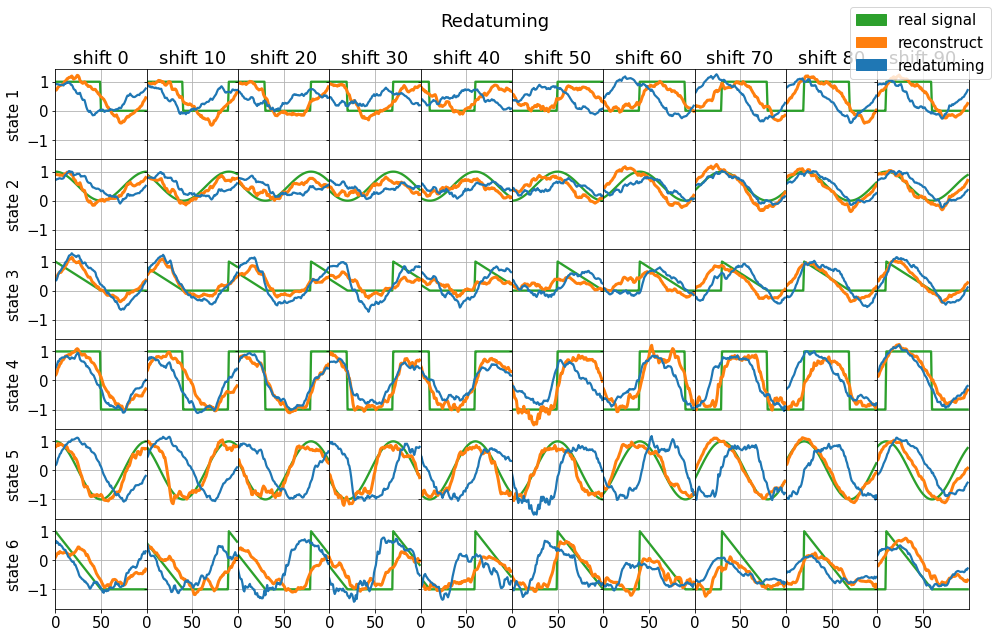

In [19]:
fig = movie_redatum(g,model)

In [14]:
model.latentcat.drop.rate

0.0

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 29.14it/s]


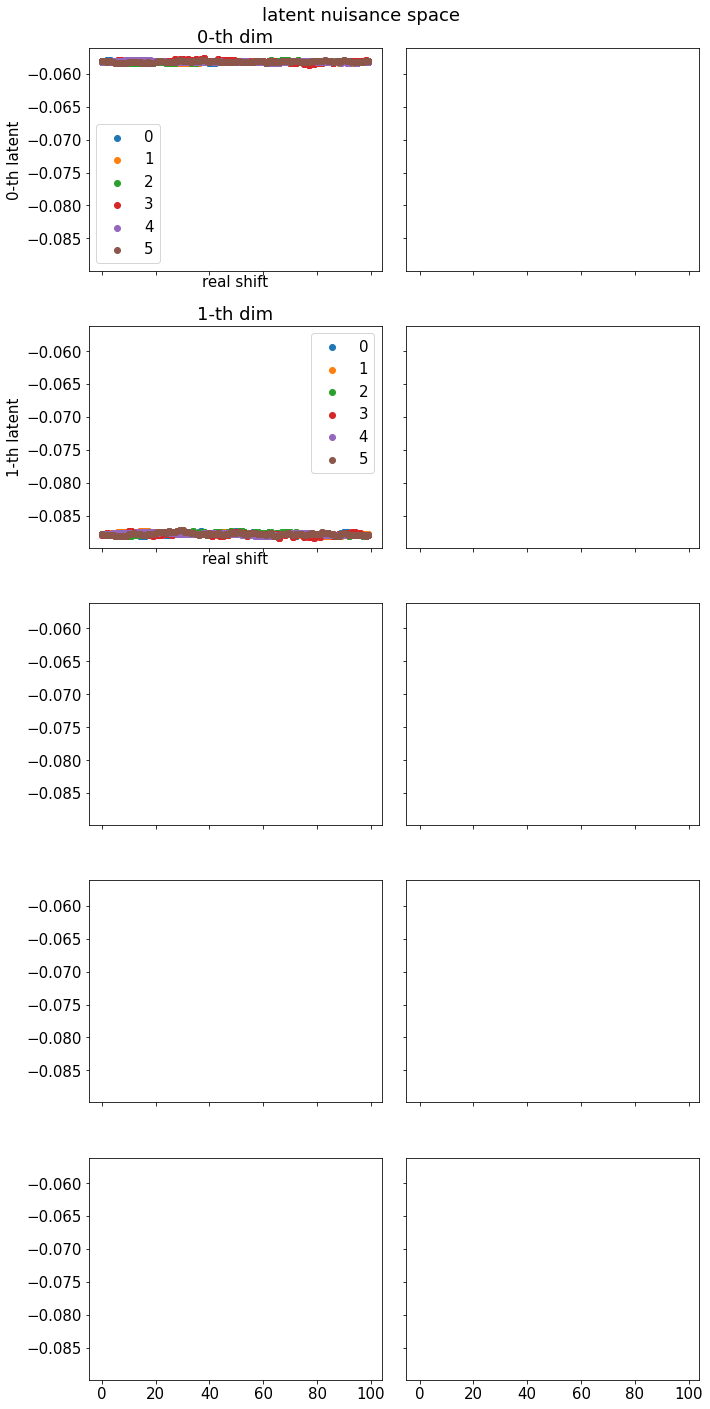

In [15]:
MRA_test = MRA_generate(d,nt,100,sigma,ne,g,replace=0,continuous=False)
MRA_test.generate_default()
clear_output()
N_code = model.nui_encoder.predict(MRA_test.X,verbose=0)
N_reshaped = N_code.reshape(-1,q)
N_states = np.repeat(MRA_test.states,nt)
N_shifts = MRA_test.shifts.reshape(-1,1)
s_sub = [N_states==s for s in range(ne)]
fig, axs = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(10,20))
for i in trange(q):
    for s in range(ne):
        ax=axs[i%5,i//5]
        ax.scatter(N_shifts[s_sub[s]],N_reshaped[:,i][s_sub[s]],color='C%d'%s,label=s)
        ax.set_title('%d-th dim'%i)
        ax.set_xlabel('real shift')
        ax.set_ylabel('%d-th latent'%i)
        ax.legend()
        ax.grid()
fig.suptitle('latent nuisance space')
fig.show()
fig.tight_layout()
fig.savefig(path+"/redatum_all.pdf", format='pdf', dpi=200)